
# ISY5002 — SAGAN for Tick-Level Order Book Data (Cleaned & Complete)

**Member:** Caleb Khoo Kei Look  
**Dataset:** XAU/USD Tick Data (Level 1 Order Book)  
**Model:** Self-Attention Generative Adversarial Network (SAGAN)

This notebook is rebuilt end-to-end with:
- Clear separation: **Section 2 has no training**; training only in Section 3
- **Padding fix** to keep time length constant (avoid GP errors)
- **Extended Evaluation** (KS, ACF, correlations, hist overlays, overlays, diversity)
- Organized folders: `data/raw`, `artifacts/windows`, `artifacts/stats`, `models`, `logs`, `figs`

---

## Table of Contents
- **Section 0:** Environment & Folders
- **Section 1:** Data Preparation (Load → Clean → Engineer → Normalize → Window)
- **Section 2:** Model Design — SAGAN (G, D, Self-Attention) *(no training here)*
- **Section 3:** Training Setup & Loop (WGAN-GP)
- **Section 4:** Extended Evaluation (Quant + Qual)


## Section 0 — Environment & Folders

In [24]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:

# Imports
import os, glob, math, json, random
from pathlib import Path
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm.auto import tqdm
import csv

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import TensorDataset, DataLoader

from datetime import datetime

pd.set_option("display.max_columns", 200)
pd.set_option("display.width", 160)

# Base project directories (change BASE if using Google Drive)
BASE = Path("/content/sagan")  # Change this if using Google Drive
DATA_RAW       = BASE / "data" / "raw" # store raw data here (tick data, etc.)
DATA_PROCESSED = BASE / "data" / "processed"
ARTIFACTS      = BASE / "artifacts"
WINDOWS_DIR    = ARTIFACTS / "windows"
STATS_DIR      = ARTIFACTS / "stats"
MODELS_DIR     = BASE / "models"
LOGS_DIR       = BASE / "logs"
FIGS_DIR       = BASE / "figs"

for d in [DATA_RAW, DATA_PROCESSED, ARTIFACTS, WINDOWS_DIR, STATS_DIR, MODELS_DIR, LOGS_DIR, FIGS_DIR]:
    d.mkdir(parents=True, exist_ok=True)

print("Project root:", BASE.resolve())
print("Folders created:")
for d in [DATA_RAW, DATA_PROCESSED, ARTIFACTS, WINDOWS_DIR, STATS_DIR, MODELS_DIR, LOGS_DIR, FIGS_DIR]:
    print(" •", d)


Project root: /content/data
Folders created:
 • /content/data/data/raw
 • /content/data/data/processed
 • /content/data/artifacts
 • /content/data/artifacts/windows
 • /content/data/artifacts/stats
 • /content/data/models
 • /content/data/logs
 • /content/data/figs



## Section 1 — Data Preparation

**Inputs:** millisecond-level ticks with columns: `timestamp, bid, ask, bid_volume, ask_volume` (one or more CSVs).  
**Steps:** Load → Clean → Feature Engineering → Normalization (session-wise) → Windowing.

> Place your raw CSVs inside `data/raw/` (e.g., `XAUUSD_Ticks_*.csv`).


In [2]:

# 1.1 Parameters & file discovery
L = 256      # sequence length
S = 32       # stride
ROLL_W = 64  # rolling std window for d_mid
EPS = 1e-6
TS_FMT = "%d.%m.%Y %H:%M:%S.%f"  # Adjust if needed

csv_files = sorted(glob.glob(str(DATA_RAW / "XAUUSD_Ticks_*.csv")))
print("Found CSV files:", len(csv_files))
for f in csv_files[:8]: print(" •", f)


Found CSV files: 5
 • /content/data/data/raw/XAUUSD_Ticks_01.08.2025-01.08.2025.csv
 • /content/data/data/raw/XAUUSD_Ticks_28.07.2025-28.07.2025.csv
 • /content/data/data/raw/XAUUSD_Ticks_29.07.2025-29.07.2025.csv
 • /content/data/data/raw/XAUUSD_Ticks_30.07.2025-30.07.2025.csv
 • /content/data/data/raw/XAUUSD_Ticks_31.07.2025-31.07.2025.csv


In [3]:

# 1.2 Load & standardize schema
dfs = []
for f in csv_files:
    try:
        df = pd.read_csv(f)
    except Exception as e:
        print("Skip (cannot read):", f, "->", e)
        continue

    df = df.rename(columns={
        "Gmt time": "timestamp",
        "Bid": "bid",
        "Ask": "ask",
        "BidVolume": "bid_volume",
        "AskVolume": "ask_volume",
    })

    # Parse timestamp as UTC
    df["timestamp"] = pd.to_datetime(df["timestamp"], format=TS_FMT, utc=True, errors="coerce")
    df = df.dropna(subset=["timestamp"])[["timestamp","bid","ask","bid_volume","ask_volume"]].copy()
    df["session"] = os.path.basename(f)  # session key per file
    dfs.append(df)

if len(dfs) == 0:
    print("No data loaded yet. You can proceed to Section 2 to review models, or add CSVs then rerun Section 1.")
    data_loaded = False
    raw = pd.DataFrame(columns=["timestamp","bid","ask","bid_volume","ask_volume","session"])
else:
    data_loaded = True
    raw = pd.concat(dfs, ignore_index=True).sort_values(["session","timestamp"]).reset_index(drop=True)

print("Loaded rows:", len(raw))
display(raw.head(10))


Loaded rows: 986664


,timestamp,bid,ask,bid_volume,ask_volume,session
0,2025-08-01 00:00:00+00:00,3288.375,3288.952,120.0,120.0,XAUUSD_Ticks_01.08.2025-01.08.2025.csv
1,2025-08-01 00:00:00.101000+00:00,3288.355,3288.952,120.0,120.0,XAUUSD_Ticks_01.08.2025-01.08.2025.csv
2,2025-08-01 00:00:00.152000+00:00,3288.355,3288.965,120.0,120.0,XAUUSD_Ticks_01.08.2025-01.08.2025.csv
3,2025-08-01 00:00:00.354000+00:00,3288.295,3288.915,120.0,120.0,XAUUSD_Ticks_01.08.2025-01.08.2025.csv
4,2025-08-01 00:00:01.108000+00:00,3288.255,3288.875,120.0,120.0,XAUUSD_Ticks_01.08.2025-01.08.2025.csv
5,2025-08-01 00:00:01.209000+00:00,3288.255,3288.835,120.0,120.0,XAUUSD_Ticks_01.08.2025-01.08.2025.csv
6,2025-08-01 00:00:01.560000+00:00,3288.205,3288.785,120.0,120.0,XAUUSD_Ticks_01.08.2025-01.08.2025.csv
7,2025-08-01 00:00:01.712000+00:00,3288.275,3288.845,120.0,120.0,XAUUSD_Ticks_01.08.2025-01.08.2025.csv
8,2025-08-01 00:00:02.114000+00:00,3288.305,3288.885,120.0,120.0,XAUUSD_Ticks_01.08.2025-01.08.2025.csv
9,2025-08-01 00:00:03.469000+00:00,3288.305,3288.852,120.0,120.0,XAUUSD_Ticks_01.08.2025-01.08.2025.csv


In [4]:

# 1.3 Cleaning
clean = raw.copy()

if data_loaded:
    # Drop exact duplicates
    clean = clean.drop_duplicates(subset=["session","timestamp","bid","ask","bid_volume","ask_volume"])

    # Coerce numerics
    for c in ["bid","ask","bid_volume","ask_volume"]:
        clean[c] = pd.to_numeric(clean[c], errors="coerce")
    clean = clean.dropna(subset=["bid","ask","bid_volume","ask_volume"])

    # Basic validity
    clean = clean[(clean["bid"] > 0) & (clean["ask"] > 0) & (clean["bid_volume"] >= 0) & (clean["ask_volume"] >= 0)]

    # Non-decreasing timestamps per session
    clean = clean.sort_values(["session","timestamp"])
    prev_ts = clean.groupby("session")["timestamp"].shift(1)
    clean = clean[(prev_ts.isna()) | (clean["timestamp"] >= prev_ts)]

    # Plausible spread for XAUUSD (adjust if needed)
    spread_tmp = clean["ask"] - clean["bid"]
    clean = clean[spread_tmp.between(0, 5, inclusive="both")].reset_index(drop=True)

print("After cleaning:", len(clean))
display(clean.head(10))


After cleaning: 986664


,timestamp,bid,ask,bid_volume,ask_volume,session
0,2025-08-01 00:00:00+00:00,3288.375,3288.952,120.0,120.0,XAUUSD_Ticks_01.08.2025-01.08.2025.csv
1,2025-08-01 00:00:00.101000+00:00,3288.355,3288.952,120.0,120.0,XAUUSD_Ticks_01.08.2025-01.08.2025.csv
2,2025-08-01 00:00:00.152000+00:00,3288.355,3288.965,120.0,120.0,XAUUSD_Ticks_01.08.2025-01.08.2025.csv
3,2025-08-01 00:00:00.354000+00:00,3288.295,3288.915,120.0,120.0,XAUUSD_Ticks_01.08.2025-01.08.2025.csv
4,2025-08-01 00:00:01.108000+00:00,3288.255,3288.875,120.0,120.0,XAUUSD_Ticks_01.08.2025-01.08.2025.csv
5,2025-08-01 00:00:01.209000+00:00,3288.255,3288.835,120.0,120.0,XAUUSD_Ticks_01.08.2025-01.08.2025.csv
6,2025-08-01 00:00:01.560000+00:00,3288.205,3288.785,120.0,120.0,XAUUSD_Ticks_01.08.2025-01.08.2025.csv
7,2025-08-01 00:00:01.712000+00:00,3288.275,3288.845,120.0,120.0,XAUUSD_Ticks_01.08.2025-01.08.2025.csv
8,2025-08-01 00:00:02.114000+00:00,3288.305,3288.885,120.0,120.0,XAUUSD_Ticks_01.08.2025-01.08.2025.csv
9,2025-08-01 00:00:03.469000+00:00,3288.305,3288.852,120.0,120.0,XAUUSD_Ticks_01.08.2025-01.08.2025.csv


In [5]:

# 1.4 Feature Engineering
fe = clean.copy()

if data_loaded and len(fe) > 0:
    fe["mid"]        = (fe["ask"] + fe["bid"]) / 2.0
    fe["spread"]     = fe["ask"] - fe["bid"]
    fe["imbalance"]  = (fe["bid_volume"] - fe["ask_volume"]) / (fe["bid_volume"] + fe["ask_volume"] + EPS)
    fe["microprice"] = (fe["ask"]*fe["bid_volume"] + fe["bid"]*fe["ask_volume"]) / (fe["bid_volume"] + fe["ask_volume"] + EPS)

    fe = fe.sort_values(["session","timestamp"])
    fe["d_mid"]    = fe.groupby("session")["mid"].diff().fillna(0.0)
    fe["d_spread"] = fe.groupby("session")["spread"].diff().fillna(0.0)
    fe["d_imb"]    = fe.groupby("session")["imbalance"].diff().fillna(0.0)

    fe["rolling_vol"] = (
        fe.groupby("session")["d_mid"].rolling(window=ROLL_W, min_periods=max(16, ROLL_W//4)).std().reset_index(level=0, drop=True)
    )
    fe["rolling_vol"] = fe["rolling_vol"].fillna(fe["rolling_vol"].median())

print("Feature engineering done. Rows:", len(fe))
display(fe.head(10))


Feature engineering done. Rows: 986664


,timestamp,bid,ask,bid_volume,ask_volume,session,mid,spread,imbalance,microprice,d_mid,d_spread,d_imb,rolling_vol
0,2025-08-01 00:00:00+00:00,3288.375,3288.952,120.0,120.0,XAUUSD_Ticks_01.08.2025-01.08.2025.csv,3288.6635,0.577,0.0,3288.663486,0.0000,0.000,0.0,0.055436
1,2025-08-01 00:00:00.101000+00:00,3288.355,3288.952,120.0,120.0,XAUUSD_Ticks_01.08.2025-01.08.2025.csv,3288.6535,0.597,0.0,3288.653486,-0.0100,0.020,0.0,0.055436
2,2025-08-01 00:00:00.152000+00:00,3288.355,3288.965,120.0,120.0,XAUUSD_Ticks_01.08.2025-01.08.2025.csv,3288.6600,0.610,0.0,3288.659986,0.0065,0.013,0.0,0.055436
3,2025-08-01 00:00:00.354000+00:00,3288.295,3288.915,120.0,120.0,XAUUSD_Ticks_01.08.2025-01.08.2025.csv,3288.6050,0.620,0.0,3288.604986,-0.0550,0.010,0.0,0.055436
4,2025-08-01 00:00:01.108000+00:00,3288.255,3288.875,120.0,120.0,XAUUSD_Ticks_01.08.2025-01.08.2025.csv,3288.5650,0.620,0.0,3288.564986,-0.0400,0.000,0.0,0.055436
5,2025-08-01 00:00:01.209000+00:00,3288.255,3288.835,120.0,120.0,XAUUSD_Ticks_01.08.2025-01.08.2025.csv,3288.5450,0.580,0.0,3288.544986,-0.0200,-0.040,0.0,0.055436
6,2025-08-01 00:00:01.560000+00:00,3288.205,3288.785,120.0,120.0,XAUUSD_Ticks_01.08.2025-01.08.2025.csv,3288.4950,0.580,0.0,3288.494986,-0.0500,0.000,0.0,0.055436
7,2025-08-01 00:00:01.712000+00:00,3288.275,3288.845,120.0,120.0,XAUUSD_Ticks_01.08.2025-01.08.2025.csv,3288.5600,0.570,0.0,3288.559986,0.0650,-0.010,0.0,0.055436
8,2025-08-01 00:00:02.114000+00:00,3288.305,3288.885,120.0,120.0,XAUUSD_Ticks_01.08.2025-01.08.2025.csv,3288.5950,0.580,0.0,3288.594986,0.0350,0.010,0.0,0.055436
9,2025-08-01 00:00:03.469000+00:00,3288.305,3288.852,120.0,120.0,XAUUSD_Ticks_01.08.2025-01.08.2025.csv,3288.5785,0.547,0.0,3288.578486,-0.0165,-0.033,0.0,0.055436


Saved stats -> /content/data/artifacts/stats/session_normalization_stats.csv


,session,n_rows,median_mid,mean_spread,std_d_mid
0,XAUUSD_Ticks_01.08.2025-01.08.2025.csv,219864,3342.00650,0.588360,0.069054
1,XAUUSD_Ticks_28.07.2025-28.07.2025.csv,182469,3324.49350,0.536418,0.057577
2,XAUUSD_Ticks_29.07.2025-29.07.2025.csv,181866,3321.65500,0.542145,0.057966
3,XAUUSD_Ticks_30.07.2025-30.07.2025.csv,206871,3303.96500,0.542838,0.067938
4,XAUUSD_Ticks_31.07.2025-31.07.2025.csv,195594,3297.21825,0.553057,0.057101


Normalization ready. Rows: 986664


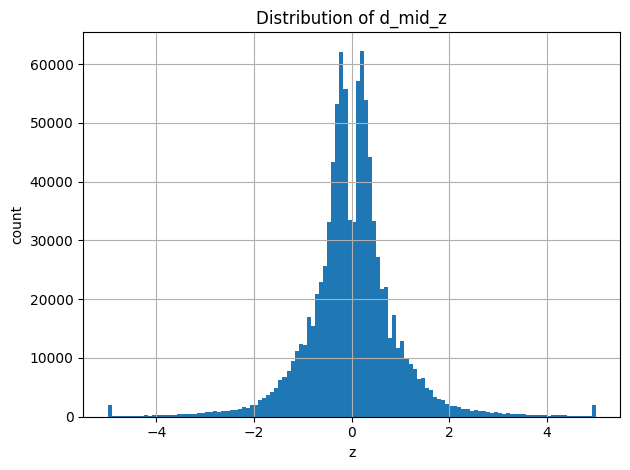

In [6]:

# 1.5 Normalization (session-wise)
norm = fe.copy()

if data_loaded and len(norm) > 0:
    grp = norm.groupby("session", group_keys=False)

    # Prices relative to session median mid
    med_mid = grp["mid"].transform("median")
    norm["mid_rel"]        = norm["mid"]        / med_mid - 1.0
    norm["microprice_rel"] = norm["microprice"] / med_mid - 1.0

    # Volumes: log1p -> z-score
    for vcol in ["bid_volume","ask_volume"]:
        logv = np.log1p(norm[vcol].clip(lower=0))
        mu   = grp[vcol].transform(lambda s: np.log1p(s.clip(lower=0)).mean())
        sd   = grp[vcol].transform(lambda s: np.log1p(s.clip(lower=0)).std()).replace(0, 1.0)
        norm[vcol + "_log1p_z"] = ((logv - mu) / sd).clip(-5, 5)

    # Other features: z-score
    z_cols = ["spread","imbalance","microprice","d_mid","d_spread","d_imb","rolling_vol"]
    for c in z_cols:
        mu = grp[c].transform("mean")
        sd = grp[c].transform("std").replace(0, 1.0)
        norm[c + "_z"] = ((norm[c] - mu) / sd).clip(-5, 5)

    # Session stats (for report)
    stats = []
    for name, g in norm.groupby("session"):
        stats.append({
            "session": name,
            "n_rows": len(g),
            "median_mid": g["mid"].median(),
            "mean_spread": g["spread"].mean(),
            "std_d_mid": g["d_mid"].std()
        })
    stats_df = pd.DataFrame(stats).sort_values("session")
    stats_df.to_csv(STATS_DIR / "session_normalization_stats.csv", index=False)
    print("Saved stats ->", STATS_DIR / "session_normalization_stats.csv")
    display(stats_df.head(10))

print("Normalization ready. Rows:", len(norm))
if "d_mid_z" in norm.columns and len(norm) > 0:
    norm["d_mid_z"].hist(bins=120)
    plt.title("Distribution of d_mid_z"); plt.xlabel("z"); plt.ylabel("count"); plt.tight_layout(); plt.show()


In [7]:

# 1.6 Windowing & save artifacts
core4 = ["mid_rel","spread_z","imbalance_z","d_mid_z"]
final_features = [
    "mid_rel","microprice_rel",
    "spread_z","imbalance_z",
    "d_mid_z","d_spread_z","d_imb_z",
    "rolling_vol_z",
    "bid_volume_log1p_z","ask_volume_log1p_z"
]

seq_full, seq_core, meta = [], [], []

if data_loaded and len(norm) > 0 and set(final_features).issubset(norm.columns):
    for name, g in norm.groupby("session"):
        g = g.sort_values("timestamp")
        A_full = g[final_features].to_numpy(dtype=np.float32)
        A_core = g[core4].to_numpy(dtype=np.float32)

        i, n = 0, len(g)
        while i + L <= n:
            seq_full.append(A_full[i:i+L])
            seq_core.append(A_core[i:i+L])
            meta.append({
                "session": name,
                "start_index": int(i),
                "end_index": int(i+L-1),
                "start_ts": g["timestamp"].iloc[i].isoformat(),
                "end_ts": g["timestamp"].iloc[i+L-1].isoformat()
            })
            i += S

X_full = np.stack(seq_full, axis=0) if len(seq_full) else np.zeros((0, L, len(final_features)), np.float32)
X_core = np.stack(seq_core, axis=0) if len(seq_core) else np.zeros((0, L, len(core4)), np.float32)

np.savez_compressed(WINDOWS_DIR / f"ticks_windowed_full_L{L}_S{S}.npz", X=X_full, features=np.array(final_features, dtype=object))
np.savez_compressed(WINDOWS_DIR / f"ticks_windowed_core4_L{L}_S{S}.npz", X=X_core, features=np.array(core4, dtype=object))

meta_df = pd.DataFrame(meta)
meta_csv = WINDOWS_DIR / f"ticks_window_meta_L{L}_S{S}.csv"
meta_df.to_csv(meta_csv, index=False)

print("Saved windowed datasets:")
print(" •", WINDOWS_DIR / f"ticks_windowed_full_L{L}_S{S}.npz", X_full.shape)
print(" •", WINDOWS_DIR / f"ticks_windowed_core4_L{L}_S{S}.npz", X_core.shape)
print(" •", meta_csv, f"({len(meta_df)} rows)")

display(meta_df.head(10))


Saved windowed datasets:
 • /content/data/artifacts/windows/ticks_windowed_full_L256_S32.npz (30796, 256, 10)
 • /content/data/artifacts/windows/ticks_windowed_core4_L256_S32.npz (30796, 256, 4)
 • /content/data/artifacts/windows/ticks_window_meta_L256_S32.csv (30796 rows)


,session,start_index,end_index,start_ts,end_ts
0,XAUUSD_Ticks_01.08.2025-01.08.2025.csv,0,255,2025-08-01T00:00:00+00:00,2025-08-01T00:01:24.670000+00:00
1,XAUUSD_Ticks_01.08.2025-01.08.2025.csv,32,287,2025-08-01T00:00:06.155000+00:00,2025-08-01T00:01:38.262000+00:00
2,XAUUSD_Ticks_01.08.2025-01.08.2025.csv,64,319,2025-08-01T00:00:10.690000+00:00,2025-08-01T00:01:45.324000+00:00
3,XAUUSD_Ticks_01.08.2025-01.08.2025.csv,96,351,2025-08-01T00:00:22.620000+00:00,2025-08-01T00:02:00.364000+00:00
4,XAUUSD_Ticks_01.08.2025-01.08.2025.csv,128,383,2025-08-01T00:00:32.446000+00:00,2025-08-01T00:02:22.741000+00:00
5,XAUUSD_Ticks_01.08.2025-01.08.2025.csv,160,415,2025-08-01T00:00:45.519000+00:00,2025-08-01T00:02:40.094000+00:00
6,XAUUSD_Ticks_01.08.2025-01.08.2025.csv,192,447,2025-08-01T00:00:59.527000+00:00,2025-08-01T00:03:02.727000+00:00
7,XAUUSD_Ticks_01.08.2025-01.08.2025.csv,224,479,2025-08-01T00:01:08.243000+00:00,2025-08-01T00:03:51.186000+00:00
8,XAUUSD_Ticks_01.08.2025-01.08.2025.csv,256,511,2025-08-01T00:01:24.771000+00:00,2025-08-01T00:04:06.501000+00:00
9,XAUUSD_Ticks_01.08.2025-01.08.2025.csv,288,543,2025-08-01T00:01:38.313000+00:00,2025-08-01T00:04:32.091000+00:00



## Section 2 — Model Design — SAGAN (no training here)

- **Generator (G):** 1D Conv backbone with residual-style stack and a simple self-attention layer.  
- **Discriminator (D):** 1D Conv encoder with spectral normalization and self-attention.  
- **No training loops** in this section — only shape sanity checks.


In [8]:

# 2.1 Device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device:", device)


Device: cuda


In [9]:

# 2.2 Self-Attention 1D
class SelfAttention1D(nn.Module):
    def __init__(self, channels):
        super().__init__()
        self.q = nn.Conv1d(channels, channels//8, 1, bias=False)
        self.k = nn.Conv1d(channels, channels//8, 1, bias=False)
        self.v = nn.Conv1d(channels, channels, 1, bias=False)
        self.gamma = nn.Parameter(torch.zeros(1))

    def forward(self, x):
        B,C,T = x.shape
        q = self.q(x).view(B, C//8, T)      # [B, C/8, T]
        k = self.k(x).view(B, C//8, T)      # [B, C/8, T]
        v = self.v(x).view(B, C, T)         # [B, C,   T]
        attn = torch.bmm(q.transpose(1,2), k) / math.sqrt(C//8 + 1e-6)  # [B, T, T]
        attn = F.softmax(attn, dim=-1)
        o = torch.bmm(v, attn.transpose(1,2))  # [B, C, T]
        return self.gamma * o + x


In [10]:

# 2.3 Generator & Discriminator with padding fix (padding=dilation to preserve L)
class Gen1D(nn.Module):
    def __init__(self, z_dim=16, out_ch=10, L=256, base=64):
        super().__init__()
        self.net = nn.Sequential(
            nn.Conv1d(z_dim, base, 3, padding=1),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv1d(base, base, 3, padding=2, dilation=2),  # keep L
            nn.LeakyReLU(0.2, inplace=True),
            SelfAttention1D(base),
            nn.Conv1d(base, base, 3, padding=4, dilation=4),  # keep L
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv1d(base, out_ch, 3, padding=1),
        )

    def forward(self, z):
        return self.net(z)

def spectral_norm(m):
    return nn.utils.spectral_norm(m)

class Disc1D(nn.Module):
    def __init__(self, in_ch=10, base=64):
        super().__init__()
        self.conv1 = spectral_norm(nn.Conv1d(in_ch, base, 3, padding=1))               # keep L
        self.conv2 = spectral_norm(nn.Conv1d(base, base, 3, padding=2, dilation=2))    # keep L
        self.attn  = SelfAttention1D(base)
        self.conv3 = spectral_norm(nn.Conv1d(base, base, 3, padding=4, dilation=4))    # keep L
        self.head  = spectral_norm(nn.Conv1d(base, 1, 1))

    def forward(self, x):
        h = F.leaky_relu(self.conv1(x), 0.2, inplace=True)
        h = F.leaky_relu(self.conv2(h), 0.2, inplace=True)
        h = self.attn(h)
        h = F.leaky_relu(self.conv3(h), 0.2, inplace=True)
        score = self.head(h).mean(dim=-1)  # [B, 1]
        return score.squeeze(1)


In [11]:

# 2.4 Instantiate models & dry-run
Z = 16
F_full = 10  # matches 'final_features'
G = Gen1D(z_dim=Z, out_ch=F_full, L=L).to(device)
D = Disc1D(in_ch=F_full).to(device)

with torch.no_grad():
    z = torch.randn(2, Z, L, device=device)
    x_fake = G(z)
    s = D(x_fake)
print("Dry-run OK — G out:", tuple(x_fake.shape), " D out:", tuple(s.shape))


Dry-run OK — G out: (2, 10, 256)  D out: (2,)



## Section 3 — Training Setup & Loop (WGAN-GP)

- **Loss:** WGAN-GP  
- **Optimizers:** Adam (β1=0.0, β2=0.9), lr_D=2e-4, lr_G=1e-4  
- **Update ratio:** k=5 *D* steps per 1 *G* step

> Training only runs if windowed data exists.


In [12]:

# 3.1 Load windowed dataset (Full features) -> DataLoader
npz_path = WINDOWS_DIR / f"ticks_windowed_full_L{L}_S{S}.npz"
if npz_path.exists():
    pack = np.load(npz_path, allow_pickle=True)
    X_full = pack["X"]    # [N, L, F]
    feats = pack["features"].tolist()
    print("Loaded windowed:", X_full.shape, "Features:", feats)
else:
    X_full = np.zeros((0, L, F_full), dtype=np.float32)
    feats = [f"f{i}" for i in range(F_full)]
    print("No windowed dataset found at:", npz_path)

if X_full.shape[0] > 0:
    X_t = torch.tensor(X_full).permute(0,2,1)  # -> [N, F, L]
    ds = TensorDataset(X_t)
    BATCH_SIZE = 64
    dl = DataLoader(ds, batch_size=BATCH_SIZE, shuffle=True, drop_last=True)
    dataset_ready = True
else:
    dl = None
    dataset_ready = False

dataset_ready


Loaded windowed: (30796, 256, 10) Features: ['mid_rel', 'microprice_rel', 'spread_z', 'imbalance_z', 'd_mid_z', 'd_spread_z', 'd_imb_z', 'rolling_vol_z', 'bid_volume_log1p_z', 'ask_volume_log1p_z']


True

In [ ]:

# 3.2 Hyperparameters & optimizers
EPOCHS = 50              # set higher (e.g., 100) on GPU
D_UPDATES = 5
LAMBDA_GP = 10.0
LR_D, LR_G = 2e-4, 1e-4
BETA1, BETA2 = 0.0, 0.9

optD = torch.optim.Adam(D.parameters(), lr=LR_D, betas=(BETA1, BETA2))
optG = torch.optim.Adam(G.parameters(), lr=LR_G, betas=(BETA1, BETA2))


In [29]:

# 3.3 Training loop with tqdm progress bar + CSV logging
from tqdm.auto import tqdm
import csv

# Logging setup
run_name = f"sagan_A_WGAN-GP_L{L}_F{X_full.shape[2] if dataset_ready else 'NA'}_DG{D_UPDATES}_bs{BATCH_SIZE}"
log_path = BASE / "data" / f"{run_name}_train_log.csv"
log_path.parent.mkdir(parents=True, exist_ok=True)

print(f"Run: {run_name}")
print(f"Logging to: {log_path}")

header = ["epoch", "iter", "loss_D", "loss_G", "gp"]
with open(log_path, "w", newline="") as f:
    csv.writer(f).writerow(header)

history = {"loss_D": [], "loss_G": [], "gp": []}

if dataset_ready:
    for epoch in range(EPOCHS):
        G.train(); D.train()
        loop = tqdm(enumerate(dl), total=len(dl), leave=True,
                    desc=f"Epoch {epoch+1}/{EPOCHS}",
                    bar_format="{l_bar}{bar:10}{r_bar}{bar:-10b}")

        for i, (xb,) in loop:
            xb = xb.to(device)

            # D updates (k steps)
            for _ in range(D_UPDATES):
                z = torch.randn(xb.size(0), Z, L, device=device)
                with torch.no_grad():
                    xf = G(z)
                D_real = D(xb)
                D_fake = D(xf)

                # Gradient penalty (inline)
                alpha = torch.rand(xb.size(0), 1, 1, device=device)
                interp = alpha * xb + (1 - alpha) * xf.detach()
                interp.requires_grad_(True)
                pred = D(interp)
                grad = torch.autograd.grad(outputs=pred.sum(), inputs=interp, create_graph=True)[0]
                gp = ((grad.norm(2, dim=(1,2)) - 1.0) ** 2).mean() * LAMBDA_GP

                loss_D = (D_fake.mean() - D_real.mean()) + gp
                optD.zero_grad(set_to_none=True)
                loss_D.backward()
                optD.step()

            # G update (1 step)
            z = torch.randn(xb.size(0), Z, L, device=device)
            xf = G(z)
            loss_G = -D(xf).mean()
            optG.zero_grad(set_to_none=True)
            loss_G.backward()
            optG.step()

            # Record + display
            d_val = float(loss_D.detach().cpu())
            g_val = float(loss_G.detach().cpu())
            gp_val = float(gp.detach().cpu())
            history["loss_D"].append(d_val)
            history["loss_G"].append(g_val)
            history["gp"].append(gp_val)

            loop.set_postfix({"D": f"{d_val:.3f}", "G": f"{g_val:.3f}", "gp": f"{gp_val:.3f}"})

            # Log each iteration
            with open(log_path, "a", newline="") as f:
                csv.writer(f).writerow([epoch+1, i, d_val, g_val, gp_val])
else:
    print("Dataset not ready — skipping training. Complete Section 1 and rerun.")


Run: sagan_A_WGAN-GP_L256_F10_DG5_bs64
Logging to: /content/data/data/sagan_A_WGAN-GP_L256_F10_DG5_bs64_train_log.csv


Epoch 1/2:   0%|          | 0/481 [00:00<?, ?it/s]

Epoch 2/2:   0%|          | 0/481 [00:00<?, ?it/s]

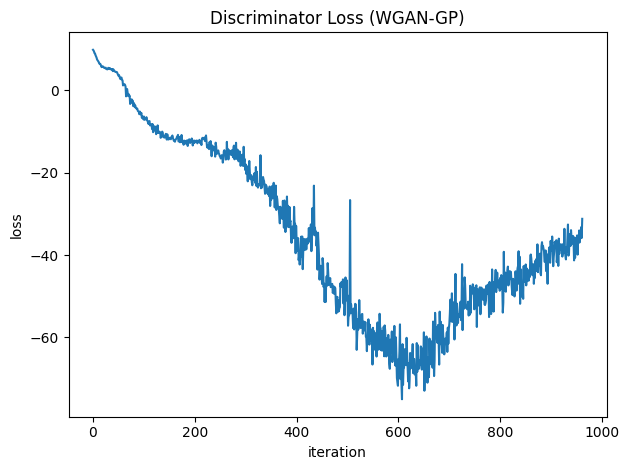

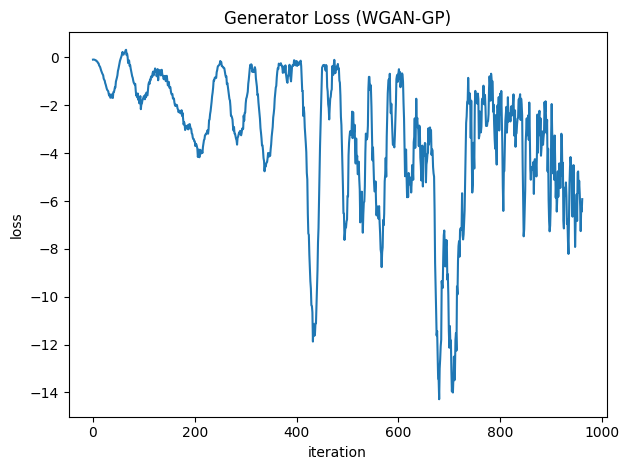

In [15]:

# 3.4 Plot losses
if len(history["loss_D"]) > 0:
    plt.figure()
    plt.plot(history["loss_D"]); plt.title("Discriminator Loss (WGAN-GP)"); plt.xlabel("iteration"); plt.ylabel("loss"); plt.tight_layout(); plt.show()

    plt.figure()
    plt.plot(history["loss_G"]); plt.title("Generator Loss (WGAN-GP)"); plt.xlabel("iteration"); plt.ylabel("loss"); plt.tight_layout(); plt.show()


In [23]:
# 3.5 Save trained model weights (after training)
if len(history["loss_D"]) > 0:
    gen_path = MODELS_DIR / f"G_SAGAN_L{L}_E{EPOCHS}.pt"
    disc_path = MODELS_DIR / f"D_SAGAN_L{L}_E{EPOCHS}.pt"
    torch.save(G.state_dict(), gen_path)
    torch.save(D.state_dict(), disc_path)
    print(f"Saved models ->\\n  {gen_path}\\n  {disc_path}")
else:
    print("No training history found — nothing saved.")

Saved models ->\n  /content/data/models/G_SAGAN_L256_E2.pt\n  /content/data/models/D_SAGAN_L256_E2.pt



## Section 4 — Extended Evaluation (Quant + Qual)

**Quantitative:** KS on z-features, histogram overlays (real vs fake), ACF for `d_mid_z` (lags 1–20), correlation matrices & Δρ, batch diversity score.  
**Qualitative:** Overlays (real vs fake) for key channels.


In [16]:

from scipy.stats import kstest

# 4.1 KS tests on z-features (from Section 1 normalization)
if 'norm' in globals() and len(norm) > 0:
    rows = []
    for c in ["spread_z","imbalance_z","d_mid_z"]:
        if c in norm.columns:
            arr = norm[c].dropna().to_numpy()
            arr = arr[np.isfinite(arr)]
            if len(arr) > 20000:
                arr = arr[::len(arr)//20000]
            ks = kstest(arr, 'norm', args=(0,1))
            rows.append({"feature": c, "KS_stat": float(ks.statistic), "p_value": float(ks.pvalue)})
    ks_df = pd.DataFrame(rows)
    print("KS vs N(0,1):")
    display(ks_df)
    ks_df.to_csv(STATS_DIR / "ks_results_section4.csv", index=False)
else:
    print("KS: normalized features unavailable (run Section 1).")


KS vs N(0,1):


,feature,KS_stat,p_value
0,spread_z,0.084921,8.784624e-127
1,imbalance_z,0.204302,0.000000e+00
2,d_mid_z,0.103300,1.572818e-187


In [17]:

# 4.2 Prepare real vs fake eval batch
eval_ready = False
if 'dataset_ready' in globals() and dataset_ready and 'G' in globals():
    G.eval()
    xb_real = next(iter(dl))[0].to(device)  # [B, F, L]
    with torch.no_grad():
        z = torch.randn(xb_real.size(0), Z, L, device=device)
        xb_fake = G(z)  # [B, F, L]
    eval_ready = True
    print("Eval batch:", xb_real.shape, xb_fake.shape)
else:
    print("Evaluation skipped: dataset/model not available.")


Eval batch: torch.Size([64, 10, 256]) torch.Size([64, 10, 256])


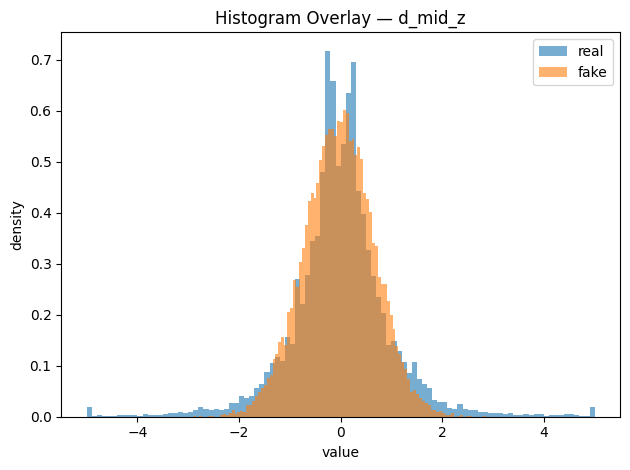

Saved: /content/data/figs/hist_overlay_d_mid_z.png


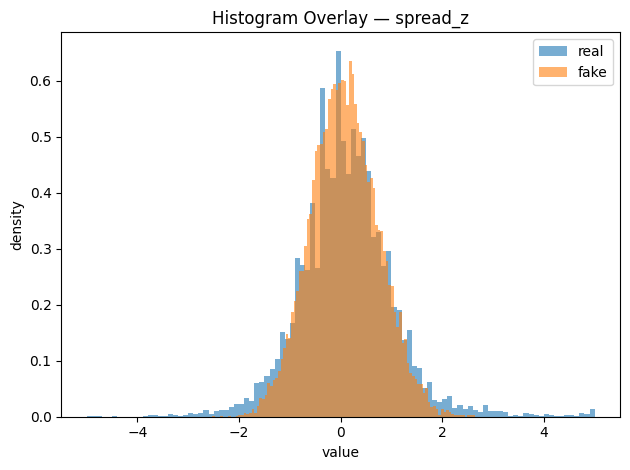

Saved: /content/data/figs/hist_overlay_spread_z.png


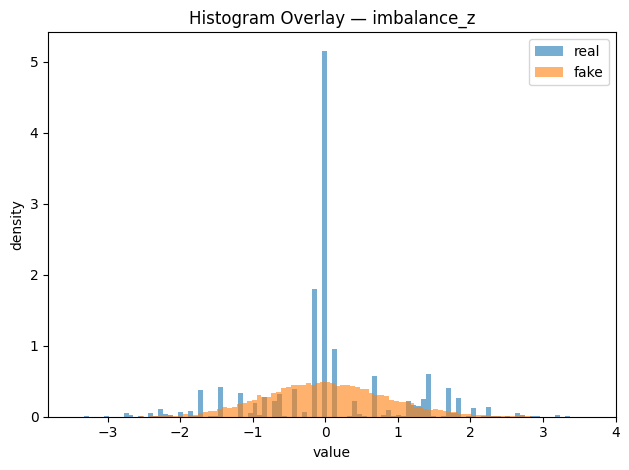

Saved: /content/data/figs/hist_overlay_imbalance_z.png


In [18]:

# 4.3 Histogram overlays (real vs fake)
if eval_ready:
    feature_names = feats if isinstance(feats, (list, tuple)) else [f"f{i}" for i in range(xb_real.size(1))]
    preferred = ["d_mid_z", "spread_z", "imbalance_z"]
    chosen = []
    for name in preferred:
        if name in feature_names:
            chosen.append((feature_names.index(name), name))
    i = 0
    while len(chosen) < 3 and i < len(feature_names):
        if i not in [c[0] for c in chosen]:
            chosen.append((i, feature_names[i]))
        i += 1

    for idx, name in chosen:
        real_flat = xb_real[:, idx, :].detach().cpu().numpy().ravel()
        fake_flat = xb_fake[:, idx, :].detach().cpu().numpy().ravel()
        plt.figure()
        plt.hist(real_flat, bins=100, density=True, alpha=0.6, label="real")
        plt.hist(fake_flat, bins=100, density=True, alpha=0.6, label="fake")
        plt.title(f"Histogram Overlay — {name}")
        plt.xlabel("value"); plt.ylabel("density"); plt.legend(); plt.tight_layout()
        outp = FIGS_DIR / f"hist_overlay_{name}.png"
        plt.savefig(outp); plt.show()
        print("Saved:", outp)
else:
    print("Skip histogram overlays: eval not ready.")


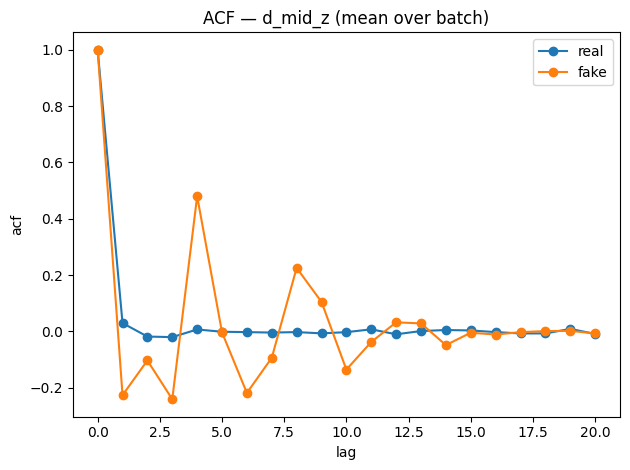

Saved: /content/data/figs/acf_d_mid_z_mean.png


In [19]:

# 4.4 ACF for d_mid_z (lags 1–20), mean over batch
if eval_ready:
    idx = feats.index("d_mid_z") if isinstance(feats, (list, tuple)) and "d_mid_z" in feats else 0
    real = xb_real[:, idx, :].detach().cpu().numpy()
    fake = xb_fake[:, idx, :].detach().cpu().numpy()
    max_lag = 20

    def acf_1d(x, max_lag):
        x = x - x.mean()
        denom = (x * x).sum() + 1e-8
        acf_vals = []
        for lag in range(max_lag+1):
            num = (x[:-lag] * x[lag:]).sum() if lag > 0 else (x * x).sum()
            acf_vals.append(num / denom)
        return np.array(acf_vals)

    real_acfs = np.stack([acf_1d(s, max_lag) for s in real], axis=0)
    fake_acfs = np.stack([acf_1d(s, max_lag) for s in fake], axis=0)
    real_mean = real_acfs.mean(axis=0); fake_mean = fake_acfs.mean(axis=0)

    plt.figure()
    plt.plot(range(max_lag+1), real_mean, marker='o', label="real")
    plt.plot(range(max_lag+1), fake_mean, marker='o', label="fake")
    plt.title("ACF — d_mid_z (mean over batch)"); plt.xlabel("lag"); plt.ylabel("acf"); plt.legend(); plt.tight_layout()
    outp = FIGS_DIR / "acf_d_mid_z_mean.png"
    plt.savefig(outp); plt.show()
    print("Saved:", outp)
else:
    print("Skip ACF: eval not ready.")


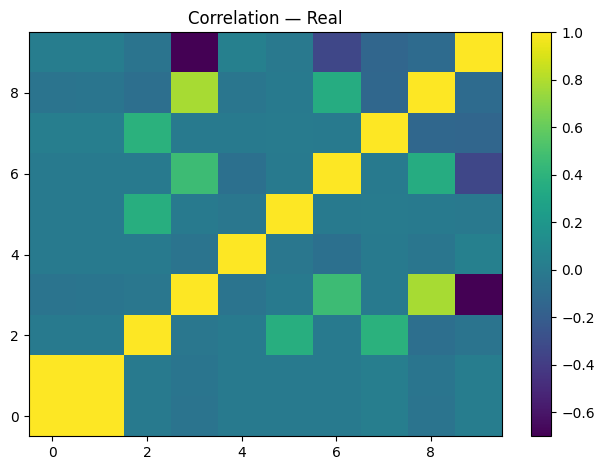

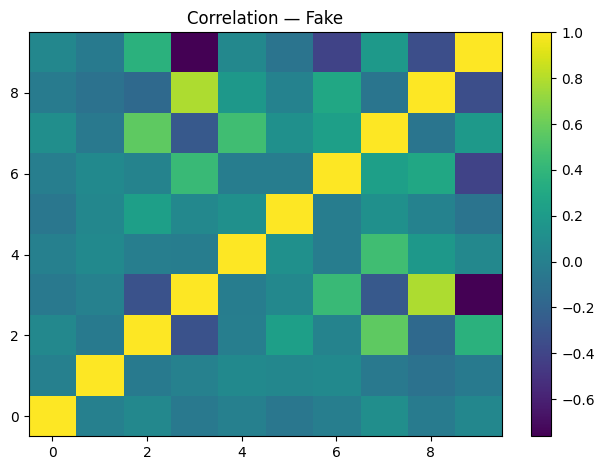

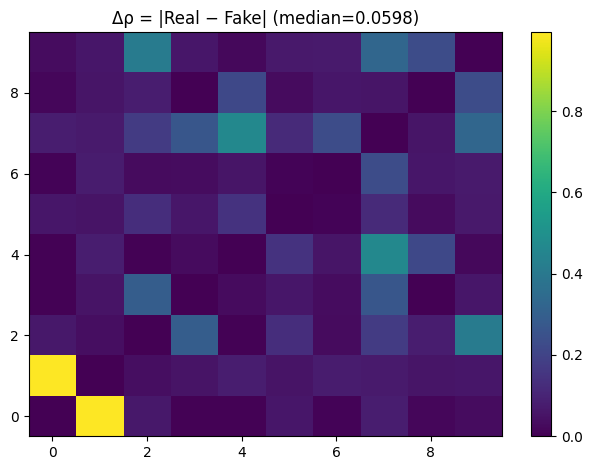

Saved correlation matrices and Δρ stats.


In [20]:

# 4.5 Correlation matrices and Δρ
if eval_ready:
    real_flat = xb_real.detach().cpu().numpy().transpose(1,0,2).reshape(xb_real.size(1), -1)  # [F, B*L]
    fake_flat = xb_fake.detach().cpu().numpy().transpose(1,0,2).reshape(xb_fake.size(1), -1)

    corr_real = np.corrcoef(real_flat)
    corr_fake = np.corrcoef(fake_flat)
    delta = np.abs(corr_real - corr_fake)
    median_delta = float(np.median(delta))

    plt.figure(); plt.imshow(corr_real, aspect='auto', origin='lower'); plt.colorbar(); plt.title("Correlation — Real"); plt.tight_layout()
    plt.savefig(FIGS_DIR / "corr_real.png"); plt.show()
    plt.figure(); plt.imshow(corr_fake, aspect='auto', origin='lower'); plt.colorbar(); plt.title("Correlation — Fake"); plt.tight_layout()
    plt.savefig(FIGS_DIR / "corr_fake.png"); plt.show()
    plt.figure(); plt.imshow(delta, aspect='auto', origin='lower'); plt.colorbar(); plt.title(f"Δρ = |Real − Fake| (median={median_delta:.4f})"); plt.tight_layout()
    plt.savefig(FIGS_DIR / "corr_delta.png"); plt.show()

    pd.DataFrame(corr_real).to_csv(STATS_DIR / "corr_real.csv", index=False)
    pd.DataFrame(corr_fake).to_csv(STATS_DIR / "corr_fake.csv", index=False)
    pd.DataFrame(delta).to_csv(STATS_DIR / "corr_delta.csv", index=False)
    with open(STATS_DIR / "corr_delta_median.txt","w") as f:
        f.write(str(median_delta))
    print("Saved correlation matrices and Δρ stats.")
else:
    print("Skip correlations: eval not ready.")


Batch diversity score: 0.441193


,feature,var
6,6,0.760283
3,3,0.684500
5,5,0.636550
8,8,0.535852
9,9,0.496417
4,4,0.458475
2,2,0.423964
7,7,0.381892
1,1,0.020649
0,0,0.013346


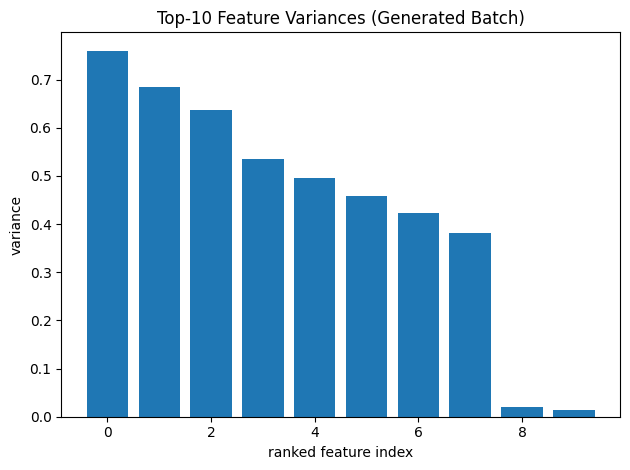

In [21]:

# 4.6 Batch diversity score (mean feature variance across generated batch)
if eval_ready:
    var_per_feat_time = xb_fake.detach().cpu().numpy().var(axis=0)  # [F, L]
    var_per_feat = var_per_feat_time.mean(axis=1)
    diversity_score = float(var_per_feat.mean())

    df_var = pd.DataFrame({"feature": list(range(len(var_per_feat))), "var": var_per_feat})
    df_var.to_csv(STATS_DIR / "batch_diversity_generated.csv", index=False)
    print("Batch diversity score:", round(diversity_score, 6))
    display(df_var.sort_values("var", ascending=False).head(10))

    plt.figure()
    topk = np.argsort(-var_per_feat)[:10]
    plt.bar(range(len(topk)), var_per_feat[topk])
    plt.title("Top-10 Feature Variances (Generated Batch)")
    plt.xlabel("ranked feature index"); plt.ylabel("variance"); plt.tight_layout()
    plt.savefig(FIGS_DIR / "diversity_top10.png"); plt.show()
else:
    print("Skip diversity score: eval not ready.")


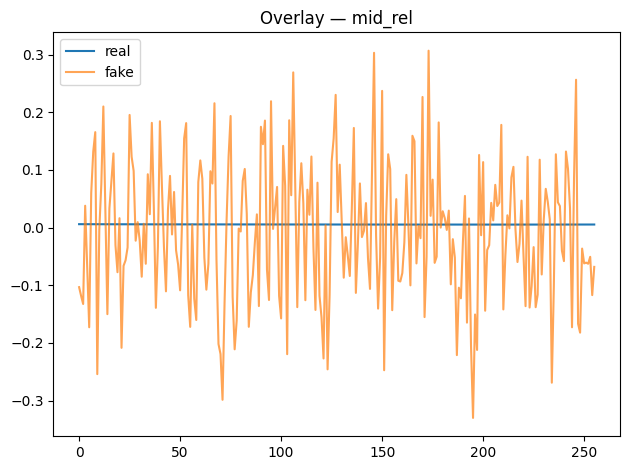

Saved overlay -> /content/data/figs/overlay_mid_rel.png


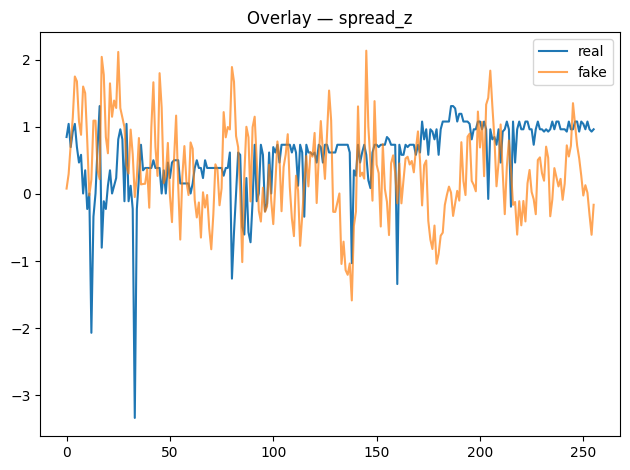

Saved overlay -> /content/data/figs/overlay_spread_z.png


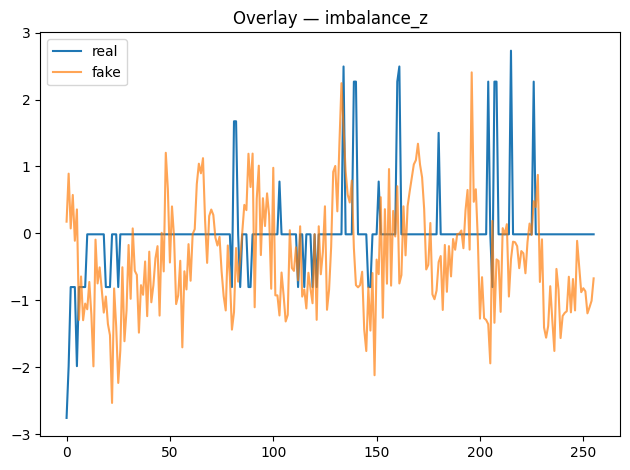

Saved overlay -> /content/data/figs/overlay_imbalance_z.png


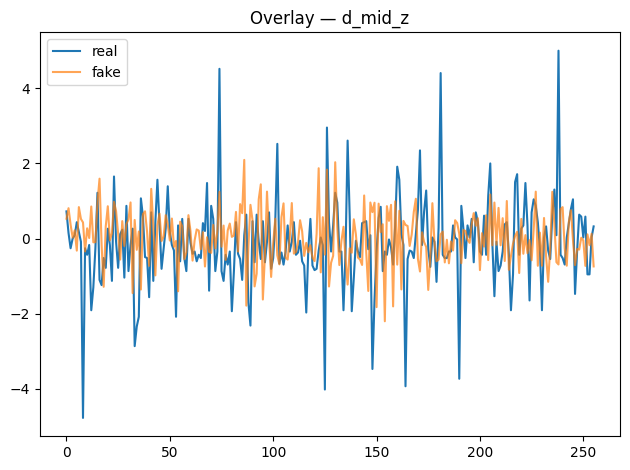

Saved overlay -> /content/data/figs/overlay_d_mid_z.png


In [22]:

# 4.7 Qualitative overlays for key channels
if eval_ready:
    to_show = ["mid_rel", "spread_z", "imbalance_z", "d_mid_z"]
    if isinstance(feats, (list, tuple)):
        for name in to_show:
            if name in feats:
                ch = feats.index(name)
                plt.figure()
                plt.plot(xb_real[0, ch].detach().cpu().numpy(), label="real")
                plt.plot(xb_fake[0, ch].detach().cpu().numpy(), label="fake", alpha=0.7)
                plt.legend(); plt.title(f"Overlay — {name}"); plt.tight_layout()
                path = FIGS_DIR / f"overlay_{name}.png"
                plt.savefig(path); plt.show()
                print("Saved overlay ->", path)
    else:
        print("Feature names unavailable; skipping named overlays.")
else:
    print("Skip overlays: eval not ready.")


In [ ]:
!zip -r /content/data.zip /content/data